
<h1>          Image Classification </h1>

Train an image classifier to recognize different species of flowers.<br>
In the dataset there are 102 categories of flowers available.



In [0]:
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import transforms,datasets,models
from torch.optim import lr_scheduler
from torch.autograd import Variable
import copy
import os

## Load the data

We use `torchvision` to load the data.<br>
Dataset available in this [link](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).

- Apply transforms on training data for better results.
- Resize inputs to 224 x 224 size.
- Since we use transfer Learning to learn from ImageNet datasets,normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data_dir='/content/drive/My Drive/Colab Notebooks/Image Classifier/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir =data_dir + '/test'

In [0]:
dir='/content/drive/My Drive/Colab Notebooks/Image Classifier/'

In [0]:
#Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir,transform=training_transforms)
valid_data = datasets.ImageFolder(valid_dir,transform=validate_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)


Map from category label to category name. You can find this in the  file `cat_to_name.json`.

In [0]:
import json

with open( dir +'cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
  

##Build And Train the Model

* Load a pre-trained network
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters


In [0]:
#select pretrained  model
model = models.densenet201(pretrained=True)
# Freeze parameters so we don't backprop through them(as these features are pretrained)
for param in model.parameters():
    param.requires_grad = False
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

<h2> Model Structure</h3>

We see that densenet201 gives 1920 features for the Classifier, which we use as input features for our classifier. We use the following structure:


---


Input Layer(1920)->Hidden Layer 1(1024) ->Hidden Layer 2(512) ->Output(102).<br>
                                           


---
Each Hidden Layer has a ReLU activation layer and a dropout.



In [0]:
#Define your model and its layers

classifier = nn.Sequential(nn.Linear(1920,1024),
                          nn.ReLU(),
                          nn.Dropout(p=0.5), 
                           nn.Linear(1024,512),
                          nn.ReLU(),
                          nn.Dropout(p=0.5), 
                          nn.Linear(512,102),
                          nn.LogSoftmax(dim=1) 
                )
model.classifier=classifier

In [0]:
#Select the Loss Function and Optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR( optimizer, step_size=5, gamma=0.1)

In [0]:
import time


In [0]:
#Validation Function

def validation(model, validloader, criterion,device):
    test_loss = 0
    accuracy = 0
    model.to(device)
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model.forward(images)
        test_loss += criterion(outputs, labels).item() 
        probabilities = torch.exp(outputs).data
        equality = (labels.data == probabilities.max(1)[1])   
        accuracy += equality.type(torch.FloatTensor).mean()
    test_loss=test_loss/len(validloader)
    accuracy= accuracy/len(validloader)
    return test_loss, accuracy

In [0]:
def train_model(model, trainloader, epochs, print_every, criterion, optimizer, device = 'cpu'):
    epochs = epochs
    print_every = print_every
    steps = 0
    start= time.time()

    # change to cuda
    model.to(device)

    for e in range(epochs):
        model.train()
        running_loss = 0
        for ii, (inputs, labels) in enumerate(trainloader):
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if steps % print_every == 0:
                model.eval()
                test_loss, accuracy = validation(model, validloader, criterion,device)
                tottime= time.time()-start
                print("Time passed: {:.0f}m {:.0f}s".format(tottime // 60, tottime % 60))
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Train Loss: {:.3f}".format(running_loss/print_every),
                     "Valid Loss: {:.3f}".format(test_loss),
                     "Valid Accuracy :{:.3f}%".format(accuracy*100))

                running_loss = 0
                model.train()

In [0]:
train_model(model, trainloader, 10, 40, criterion, optimizer, 'cuda')

Time passed: 16m 2s
Epoch: 1/10...  Train Loss: 4.161 Valid Loss: 3.707 Valid Accuracy :18.404%
Time passed: 25m 11s
Epoch: 1/10...  Train Loss: 3.545 Valid Loss: 2.782 Valid Accuracy :38.212%
Time passed: 30m 57s
Epoch: 2/10...  Train Loss: 1.157 Valid Loss: 2.030 Valid Accuracy :54.938%
Time passed: 32m 12s
Epoch: 2/10...  Train Loss: 2.337 Valid Loss: 1.540 Valid Accuracy :65.139%
Time passed: 33m 27s
Epoch: 2/10...  Train Loss: 2.051 Valid Loss: 1.239 Valid Accuracy :68.798%
Time passed: 34m 40s
Epoch: 3/10...  Train Loss: 1.520 Valid Loss: 1.017 Valid Accuracy :74.394%
Time passed: 35m 54s
Epoch: 3/10...  Train Loss: 1.620 Valid Loss: 0.905 Valid Accuracy :79.284%
Time passed: 37m 8s
Epoch: 4/10...  Train Loss: 0.394 Valid Loss: 0.759 Valid Accuracy :81.976%
Time passed: 38m 22s
Epoch: 4/10...  Train Loss: 1.252 Valid Loss: 0.652 Valid Accuracy :85.774%
Time passed: 39m 37s
Epoch: 4/10...  Train Loss: 1.276 Valid Loss: 0.603 Valid Accuracy :86.168%
Time passed: 40m 51s
Epoch: 5/10

##Testing and Saving the Model

Testing model on test data never seen during training or validation to estimate performance on new images.


In [0]:
model.eval()

with torch.no_grad():
    test_loss, accuracy = validation(model,testloader, criterion,'cuda')
print("Test loss = ", test_loss)
print("Accuracy :{:.3f}%".format(accuracy*100))

KeyboardInterrupt: ignored

<h3>Save the model so you can load it later for making predictions</h3>

In [0]:
def save_checkpoint(state, filename=dir+'checkpoint.pth'):
    torch.save(state, filename)

In [0]:
save_checkpoint({
    'epoch': 15,
    'arch': 'densenet201',
    'classifier': classifier,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'mapping': train_data.class_to_idx,
    'criterion': criterion
})

<h3>Load the saved model for making predictions</h3>

In [0]:
def load_checkpoint(filepath):
    if os.path.isfile(filepath):
        print(f'Loading checkpoint {filepath}')
        checkpoint = torch.load(filepath)
        network = models.__dict__[checkpoint['arch']](pretrained=True)
        network.classifier = checkpoint['classifier']      
        network.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        network.class_to_idx = checkpoint['mapping']
        criterion = checkpoint['criterion']
        return network,criterion

    else:
        print(f'No checkpoint found at: {filepath}')

In [0]:
loaded_network,loaded_criterion = load_checkpoint('checkpoint.pth')

Loading checkpoint checkpoint.pth


In [0]:
loaded_network.eval()
with torch.no_grad():
    test_loss, accuracy = validation(loaded_network ,testloader, loaded_criterion,'cuda')
print("Test loss = ", test_loss)
print("Accuracy :{:.3f}%".format(accuracy*100))

Test loss =  0.37490819566524947
Accuracy :89.569%


##Inference 

Take an image and a model, then returns the top $K$ most likely classes along with the probabilities.



In [0]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from PIL import Image


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<h2>Image Preprocessing</h2>

Preprocess the image so it can be used as input for the model. This function should process the images in the same manner used for training.
Matplotlib needs a Numpy array to display images, while Pytorch requires tensor as input.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    im = Image.open(image)
    
    target_size = 256
    width, height = im.size
    aspect_ratio = width / height
    im.resize((target_size, int(aspect_ratio * target_size)))

    
    # Resize with resize function keeping aspect ratio
    target_size = 256
    width, height = im.size
    ratio = width / height
    if width <= height: 
        im = im.resize((target_size, int(ratio * target_size)))
    else:
        im = im.resize((int(ratio * target_size), target_size))
    
    # Crop Image
    crop_size = 224
    left = (im.size[0] - crop_size)/2
    top = (im.size[1] - crop_size)/2
    right = (im.size[0] + crop_size)/2
    bottom = (im.size[1] + crop_size)/2
    im = im.crop((left, top, right, bottom))
    
    # normalization of colors    
    np_image = np.array(im) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean)/std
    np_image = np_image.transpose((2, 0, 1))
   
    
    return np_image

<h2>Display Image</h2>

In [0]:
test_image_path = test_image = test_dir+ '/79/image_06708.jpg'
test_processed_images = process_image(test_image_path)

NameError: ignored

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

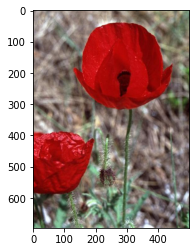

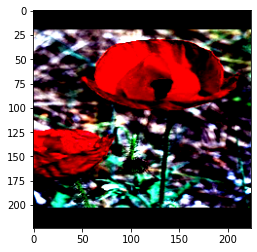

In [0]:
# display original image
image = Image.open(test_image_path)
ax=None
if ax is None:
    fig, ax = plt.subplots()
ax.imshow(image)

# display edited image
img = test_processed_images.transpose((1, 2, 0))
img = np.clip(img, 0, 1)
ax=None
if ax is None:
    fig, ax = plt.subplots()
ax.imshow(img)

<h2>Predict Top 5 probable Classes</h2>

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    with torch.no_grad():
        model.eval()
        
        np_image = process_image(image_path)
        image_tensor = torch.from_numpy(np_image)

        if device == 'cuda':
            model.to('cuda')
            inputs = Variable(image_tensor.float().cuda()) 
        else:
            model.to('cpu')
            inputs = Variable(image_tensor.float())    
             
        output = model.forward(inputs.unsqueeze(0))
        ps = torch.exp(output).topk(5)
        probs = ps[0].cpu()
        classes = ps[1].cpu()
        
        # Convert indices to classes
        idx_to_class = {val: key for key, val in model.class_to_idx.items()}
        top_classes = [idx_to_class[each] for each in classes.numpy()[0]]
        
        name_list = []
        with open(dir+'cat_to_name.json') as file:
            data = json.load(file)
            for flower_id in top_classes:
                 name_list.append(data[str(flower_id)])
                          
    return probs.numpy()[0].tolist(), name_list


In [0]:
def display_result(probs, classes):
    imshow(process_image(test_image_path), None, classes)
    plt.figure(figsize = [3.5, 4])
    bin_edges = np.arange(len(classes)-1, -1, -1)
    plt.yticks(bin_edges, classes)
    plt.barh(bin_edges, probs)

device is:  cuda
['corn poppy', 'anthurium', 'camellia', 'trumpet creeper', 'rose']
[0.6918961405754089, 0.13896284997463226, 0.039413951337337494, 0.03132084384560585, 0.023524373769760132]


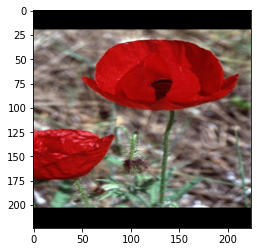

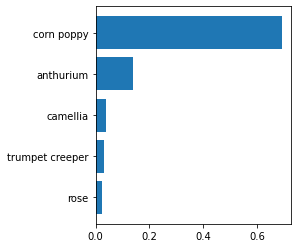

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('device is: ', device)
probs, classes = predict(test_image_path, loaded_network)
print(classes)
print(probs)
display_result(probs, classes)